In [1]:
from os import path

import random
import numpy as np

import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary

import matplotlib.pyplot as plt

import dataloaders
import networks.utils as utils
import networks.sncdcgan as sncdcgan

### Setup CUDA / Multiprocessing related variables

In [2]:
USE_CUDA = True

if USE_CUDA and torch.cuda.is_available():
    device = 'cuda' #alt: "cuda:0"
else:
    device = 'cpu'

PIN_MEMORY = True
USE_MULTI_PROCESS_DATA_LOADING = True
# Multi Process Data Loading
if USE_MULTI_PROCESS_DATA_LOADING:
    NUM_THREADS = torch.get_num_threads()
    print("Number of Threads: ", NUM_THREADS)
else:
    NUM_THREADS = 0
    print("Not using Multi-Process Data Loading.")

Number of Threads:  8


### Setup Parameters

In [3]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED);

In [4]:
### Data
DATA_PATH = path.join("data","tmdb-64")
TABLE_PATH = path.join("data","tmdb-movies-220923-clean.pkl")

### Architecture
IMAGE_SIZE = 64
IMAGE_SIZE_RATIO = 3 # height/width
NUM_IMG_CHANNELS = 3
NUM_NOISE_VEC_CHANNELS = 100
NUM_FEATURE_VEC_CHANNELS = 37
BASE_NUM_OUT_CHANNELS_G = 128
BASE_NUM_OUT_CHANNELS_D = 64
D_NORM_LAYER_TYPE = "instance"
PADDING_MODE = "reflect"
COLORMODE="RGB"

### Training
BATCH_SIZE = 128
NUM_EPOCHS = 2
LEARNING_RATE = 0.0001
BETA1 = 0. #formerly 0.5
BETA2 = 0.9 #formerly 0.999
N_CRITIC = 5
LAMBDA_GP = 10

### Visualization
NUM_SAMPLES = 64

### Saving
OUT_PATH = path.join("output-runs","sncdcgan-output")
SAVE_MODEL_EVERY_N_EPOCHS = 1
SAVE_FAKES_EVERY_N_EPOCHS = 1

### Load dataset

In [5]:
# Poster subset:
GENRE=None
GENRE_LOGIC='and'
OG_LANG=None
YEAR=None
RUNTIME=(40, np.inf)
MAX_NUM=None
SORT=None

# define dataset
poster_dataset = dataloaders.PosterDataset(table_path=TABLE_PATH, img_root_path=DATA_PATH,
                                    img_transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                                    colormode=COLORMODE,
                                    img_in_ram=False,
                                    genre=GENRE, genre_logic=GENRE_LOGIC, og_lang=OG_LANG, year=YEAR, runtime=RUNTIME,
                                    max_num=MAX_NUM, sort=SORT)
posterloader = torch.utils.data.DataLoader(poster_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_THREADS, pin_memory=True)

Sample dataset:

The dataset has 224094 entries.


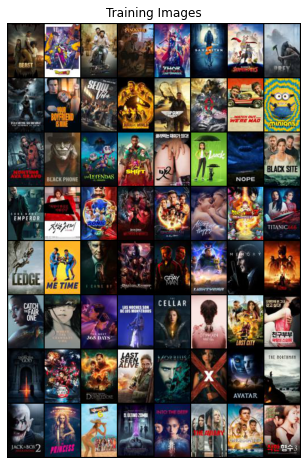

In [6]:
sample_reals = utils.sample_posters(posterloader, number_of_samples=NUM_SAMPLES, colormode=COLORMODE, device=device)
print('The dataset has ' + str(len(poster_dataset)) + ' entries.');

In [7]:
sample_labels = torch.stack(sample_reals[6:43], dim=1).type(torch.FloatTensor).to(device)[:NUM_SAMPLES]
sample_labels_generator = sample_labels[:, :, None, None].expand(NUM_SAMPLES, NUM_FEATURE_VEC_CHANNELS, 3, 1)

### Initialize Network

In [8]:
generator, discriminator = sncdcgan.create_gan(num_img_channels=NUM_IMG_CHANNELS, num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G, base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D, padding_mode=PADDING_MODE, num_feature_vec_channels=NUM_FEATURE_VEC_CHANNELS, device=device)

print("Generator:")
summary(generator, input_size=[(NUM_NOISE_VEC_CHANNELS, 3, 1),(NUM_FEATURE_VEC_CHANNELS, 3, 1)])
print("\nDiscriminator:")
summary(discriminator, input_size=[(3, 96, 64), (NUM_FEATURE_VEC_CHANNELS, 96, 64)])

Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 6, 4]         819,200
       BatchNorm2d-2            [-1, 512, 6, 4]           1,024
   ConvTranspose2d-3            [-1, 512, 6, 4]         303,104
       BatchNorm2d-4            [-1, 512, 6, 4]           1,024
   ConvTranspose2d-5           [-1, 512, 12, 8]       8,388,608
       BatchNorm2d-6           [-1, 512, 12, 8]           1,024
   ConvTranspose2d-7          [-1, 256, 24, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 24, 16]             512
   ConvTranspose2d-9          [-1, 128, 48, 32]         524,288
      BatchNorm2d-10          [-1, 128, 48, 32]             256
  ConvTranspose2d-11            [-1, 3, 96, 64]           6,144
Total params: 12,142,336
Trainable params: 12,142,336
Non-trainable params: 0
----------------------------------------------------------------
Input size (M

In [9]:
trainer = sncdcgan.create_trainer(out_dir=OUT_PATH, num_samples=NUM_SAMPLES, colormode=COLORMODE, num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, image_size_ratio=IMAGE_SIZE_RATIO, d_params=discriminator.parameters(), g_params=generator.parameters(), learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2, device=device)

## Train

In [11]:
SHOW_GRAPHS = False

trainer.train(generator, discriminator, num_features=NUM_FEATURE_VEC_CHANNELS, dataloader=posterloader, num_epochs=NUM_EPOCHS, device=device, show_graphs=SHOW_GRAPHS, sample_labels_generator=sample_labels_generator)

[0/1]	Loss_D: 1.3680	Loss_G: 0.6356	D(x): 0.5506	D(G(z)): 0.5294 / 0.5316: 100%|██████████| 1751/1751 [17:19<00:00,  1.68it/s]
[1/1]	Loss_D: 1.3770	Loss_G: 0.6856	D(x): 0.5092	D(G(z)): 0.5036 / 0.5039: 100%|██████████| 1751/1751 [16:31<00:00,  1.77it/s]


### Show results

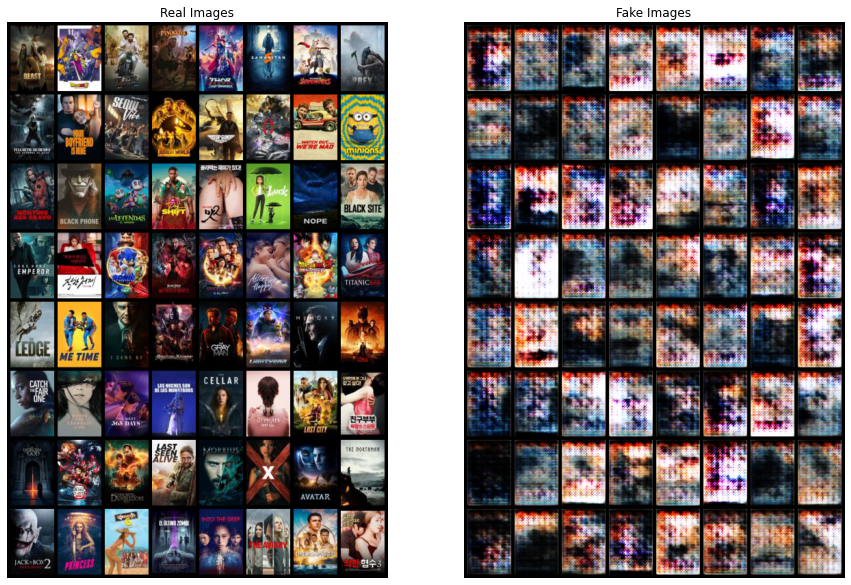

In [12]:
with torch.no_grad():
    sample_fakes = generator(trainer.noise_samples, sample_labels_generator).detach().cpu()
sample_fakes = vutils.make_grid(sample_fakes, padding=5, normalize=True)

fig = plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(sample_reals[0].to(device)[:NUM_SAMPLES], padding=5, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(sample_fakes, (1, 2, 0)))
plt.show()

fig.savefig(path.join(trainer.last_out_dir, "real_vs_fake.png"))